In [19]:
# result = ts.get_hs300s()
# result.head()
# result.to_csv('/Users/zi-qinzhou/Documents/LearnBySelf/Quant/hs300.csv',encoding='utf-8-sig')
# data = pd.read_csv('hs300.csv') 
# print(result['name'].head())

In [92]:
import csv
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

# Preprocessing Data
### 1. Downloading Data

In [3]:
data = ts.get_h_data('000300', index = True, start = '2015-01-01', end = '2016-01-01')

[Getting data:]####

In [4]:
data = data.sort_index(ascending=True)#升序
data.tail()

,open,high,close,low,volume,amount
date,,,,,,
2015-12-25,3832.085,3848.025,3838.201,3813.204,11962401300,163314511431
2015-12-28,3847.532,3853.389,3727.632,3727.632,15398844000,210026020459
2015-12-29,3723.050,3762.052,3761.875,3710.480,10188555500,140405054699
2015-12-30,3762.914,3765.657,3765.175,3726.278,10562995500,155744099319
2015-12-31,3760.904,3772.617,3731.005,3727.325,10187355600,145043696235


### 2. Features Fuction

In [22]:
def CCI(data, ndays):
    TP = (data['high'] + data['low'] + data['close']) / 3
    CCI = pd.Series((TP - pd.DataFrame.rolling(TP, ndays).mean()) / (0.015 * pd.DataFrame.rolling(TP, ndays).std()),
    name = 'CCI')
    result = pd.DataFrame(CCI)
    return result

def EVM(data, ndays):
    dm = ((data['high'] + data['low'])/2) - ((data['high'].shift(1) + data['low'].shift(1))/2)
    br = (data['volume'] / 100000000) / ((data['high'] - data['low']))
    EVM = dm / br
    EVM_MA = pd.Series(pd.DataFrame.rolling(EVM, ndays).mean(), name = 'EVM')
    result = pd.DataFrame(EVM_MA)
    return result

def SMA(data, ndays):
    SMA = pd.Series(pd.DataFrame.rolling(data['close'], ndays).mean(), name = 'SMA')
    result = pd.DataFrame(SMA)
    return result

def ROC(data,n):
    N = data['close'].diff(n)
    D = data['close'].shift(n)
    ROC = pd.Series(N/D,name='Rate of Change')
    result = pd.DataFrame(ROC)
    return result

def BBANDS(data, ndays):
    MA = pd.Series(pd.DataFrame.rolling(data['close'], ndays).mean())
    SD = pd.Series(pd.DataFrame.rolling(data['close'], ndays).std())

    b1 = MA + (2 * SD)
    B1 = pd.Series(b1, name = 'Upper BollingerBand')
    data = data.join(B1)

    b2 = MA - (2 * SD)
    B2 = pd.Series(b2, name = 'Lower BollingerBand')
    result = pd.DataFrame(B2)
    return result

def ForceIndex(data, ndays): 
    FI = pd.Series(data['close'].diff(ndays) * data['volume'], name = 'ForceIndex') 
    result = pd.DataFrame(FI) 
    return result

### 3. Building Training Datasets

In [104]:
final = pd.concat([CCI(data,5), EVM(data,5), SMA(data,5), ROC(data,5), BBANDS(data,5),ForceIndex(data,5)], axis=1)
final.dropna().head()

,CCI,EVM,SMA,Rate of Change,Lower BollingerBand,ForceIndex
date,,,,,,
2015-01-12,-105.969604,-8.018640,3580.8814,-0.035140,3463.650104,-3.411127e+12
2015-01-13,-62.966672,-8.473673,3555.4776,-0.034885,3448.880974,-2.377211e+12
2015-01-14,-57.391363,-9.535103,3527.2042,-0.038797,3478.402298,-2.770970e+12
2015-01-15,45.053627,-3.847704,3536.1766,0.012604,3453.304471,1.066874e+12
2015-01-16,108.078685,-0.651911,3553.8612,0.024931,3431.436611,2.499556e+12


In [102]:
temp_target = data.close.diff().apply(lambda x: 1 if x>=0 else 0)
temp_target.head()

date
2015-01-05    0
2015-01-06    0
2015-01-07    1
2015-01-08    0
2015-01-09    0
Name: close, dtype: int64

In [25]:
final['target'] = temp_target

In [29]:
final.dropna(inplace = True)

In [103]:
final.head()

,CCI,EVM,SMA,Rate of Change,Lower BollingerBand,ForceIndex,target
date,,,,,,,
2015-01-12,-105.969604,-8.018640,3580.8814,-0.035140,3463.650104,-3.411127e+12,0
2015-01-13,-62.966672,-8.473673,3555.4776,-0.034885,3448.880974,-2.377211e+12,1
2015-01-14,-57.391363,-9.535103,3527.2042,-0.038797,3478.402298,-2.770970e+12,0
2015-01-15,45.053627,-3.847704,3536.1766,0.012604,3453.304471,1.066874e+12,1
2015-01-16,108.078685,-0.651911,3553.8612,0.024931,3431.436611,2.499556e+12,1


# Training Data

### 1. Let's see what's the data looking like

In [40]:
X = final.drop(['target'], axis=1)
Y = final.target
print(X.head())
print(Y.head())

                   CCI       EVM        SMA  Rate of Change  \
date                                                          
2015-01-12 -105.969604 -8.018640  3580.8814       -0.035140   
2015-01-13  -62.966672 -8.473673  3555.4776       -0.034885   
2015-01-14  -57.391363 -9.535103  3527.2042       -0.038797   
2015-01-15   45.053627 -3.847704  3536.1766        0.012604   
2015-01-16  108.078685 -0.651911  3553.8612        0.024931   

            Lower BollingerBand    ForceIndex  
date                                           
2015-01-12          3463.650104 -3.411127e+12  
2015-01-13          3448.880974 -2.377211e+12  
2015-01-14          3478.402298 -2.770970e+12  
2015-01-15          3453.304471  1.066874e+12  
2015-01-16          3431.436611  2.499556e+12  
date
2015-01-12    0
2015-01-13    1
2015-01-14    0
2015-01-15    1
2015-01-16    1
Name: target, dtype: int64


### 2. Using random forest to train the data

In [99]:
forest = RandomForestClassifier(n_estimators=10,
                              random_state=0)

forest.fit(X, Y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

### 3. Feather importance and sorting the feather list in importance descending order

In [100]:
print(indices)
print(importances)
names = X.columns.tolist()

[0 1 5 3 4 2]
[ 0.29419917  0.1903317   0.0967372   0.14488776  0.11023684  0.16360733]


### 4. Plot the feather importances

Feature ranking:
1. feature CCI (0.294199)
2. feature EVM (0.190332)
3. feature ForceIndex (0.163607)
4. feature Rate of Change (0.144888)
5. feature Lower BollingerBand (0.110237)
6. feature SMA (0.096737)
['CCI', 'EVM', 'ForceIndex', 'Rate of Change', 'Lower BollingerBand', 'SMA']


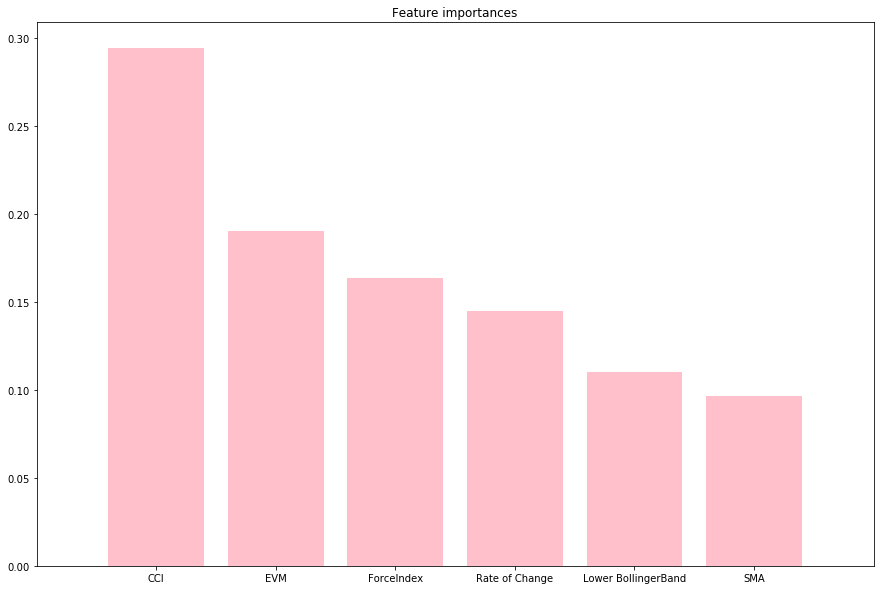

In [105]:
# Print the feature ranking
print("Feature ranking:")
x_pin = []
for f in range(X.shape[1]): 
    print("%d. feature %s (%f)" % (f + 1, names[(indices[f])], importances[indices[f]]))
    x_pin.append(names[indices[f]])

    # Plot the feature importances of the forest
print(x_pin)
plt.figure(1, facecolor='w', figsize=(15, 10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="pink")
plt.xticks(range(X.shape[1]), x_pin)
plt.xlim([-1, X.shape[1]])
plt.show()